# BEE 4750 Homework 2: Dissolved Oxygen

**Name**: Akshara Chandrabalan

**ID**: ac2837

> **Due Date**
>
> Friday, 09/22/23, 9:00pm

## Overview

### Instructions

This assignment asks you to use a simulation model for dissolved oxygen
to assess the impacts of two wastewater streams, including minimum
treatment levels and the impact of uncertain environmental conditions.
You will also be asked to identify a minimum distance for the addition
of a third discharge stream.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [80]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/BEE 5750 /hw02-akshara-c`


In [81]:
using Plots
using LaTeXStrings
using Distributions
using Random # random number generation

## Problems (Total: 40 Points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart, as shown in
<a href="#fig-river" class="quarto-xref">Figure 1</a>. The oxygen
reaeration rate is 0.55 day<sup>-1</sup>, and the decay rates of CBOD
and NBOD are are 0.35 and 0.25 day<sup>-1</sup>, respectively. The
river’s saturated dissolved oxygen concentration is 10m g/L.

![Figure 1: Schematic of the
system](attachment:figures/river_diagram.png)

### Problem 1 (8 points) 

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

|    Parameter     |            River Inflow |         Waste Stream 1 |         Waste Stream 2 |
|:----------------:|------------------------:|-----------------------:|-----------------------:|
|      Inflow      | 100,000 L</sup>/d | 10,000 L</sup>/d | 15,000 L</sup>/d |
| DO Concentration |                7.5 mg/L |                 5 mg/L |                 5 mg/L |
|       CBOD       |                  5 mg/L |                50 mg/L |                45 mg/L |
|       NBOD       |                  5 mg/L |                35 mg/L |                35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

In [82]:
# river, waste stream 1, and waste stream 2 inflows
r_in = 100000
ws1_in = 10000
ws2_in = 15000
# given DO concentration for waste stream 1 and 2
ws1_Ci = 5
ws2_Ci = 5
# given river inflow CBOD and NBOD concentration
r_Bi = 5
r_Ni = 5

function diss_O2(d, Cs, r_Ci, ws1_Bi, ws2_Bi, ws1_Ni, ws2_Ni, ka, kc, kn, U) # outputs DO concentration at a given distance d downstream
    # computing initial values (mixed concentrations) 
    C0 = ((r_Ci * r_in) + (ws1_Ci * ws1_in))/(r_in + ws1_in) 
    B0 = ((r_Bi * r_in) + (ws1_Bi * ws1_in))/(r_in + ws1_in)
    N0 = ((r_Ni * r_in) + (ws1_Ni * ws1_in))/(r_in + ws1_in)
    
    if (d >= 0) && (d <= 15) # box 1: first 15 km downstream i.e. just uptill ws2
        α1 = exp(-ka * d / U) 
        α2 = (kc / (ka - kc)) * (exp(-kc * d / U) - α1)
        α3 = (kn / (ka - kn)) * (exp(-kn * d / U) - α1)

        C = (Cs * (1 - α1)) + (C0 * α1) - (B0 * α2) - (N0 * α3)
        return C
    else (d > 15) # box 2: from ws2 onwards 
        d2 = d - 15 # resetting distance, so d = 0 is now where ws2 is

        α1 = exp(-ka * d2 / U) 
        α2 = (kc / (ka - kc)) * (exp(-kc * d2 / U) - α1)
        α3 = (kn / (ka - kn)) * (exp(-kn * d2 / U) - α1)

        C15 = 4.88 # calculated manually
        # new initial state values (15 km downstream) considering outflows from box 1
        C15_mix = (((C15 * (r_in + ws1_in)) + (ws2_Ci * ws2_in))/(r_in + ws1_in + ws2_in))   
        B15_mix = (((B0 * exp(-kc * 15 / U)) * (r_in + ws1_in)) + (ws2_Bi * ws2_in))/(r_in + ws1_in + ws2_in) # B(x) = B0exp(-kc*x/U) 
        N15_mix = (((N0 * exp(-kn * 15 / U)) * (r_in + ws1_in)) + (ws2_Ni * ws2_in))/(r_in + ws1_in + ws2_in) # N(x) = N0exp(-kn*x/U)

        C = (Cs * (1 - α1)) + (C15_mix * α1) - (B15_mix * α2) - (N15_mix * α3)
        return C
    end  
end

diss_O2 (generic function with 1 method)

In [84]:
# finding min DO within 50 km downstream
d = collect(0:0.1:50)
C_val = []
for i = 1:length(d) # calculating DO concentration from 0 to 50 km at intervals of 0.1
    C = diss_O2(d[i], 10, 7.5, 50, 45, 35, 35, 0.55, 0.35, 0.25, 6) 
    append!(C_val, C)
end

min_DO = findmin(C_val) # findmin outputs a 2-element array, [1] is the min value of the input array and [2] is the index of the min value
C_min = round(min_DO[1]; digits = 2)
@show C_min
C_min_dist = d[min_DO[2]]; # note: each element in array d corresponds to an element in C_val
@show C_min_dist;



C_min = 3.75
C_min_dist = 22.3


ANSWER: I decided to find the minimum DO concentration up to 50 km downstream, which is about 3.75 mg/L, and it occurs around 22.3 km downstream.

### Problem 2 (4 points)

Use your model to plot the dissolved oxygen concentration in the river
from the first waste stream to 50km downstream. What do you notice?

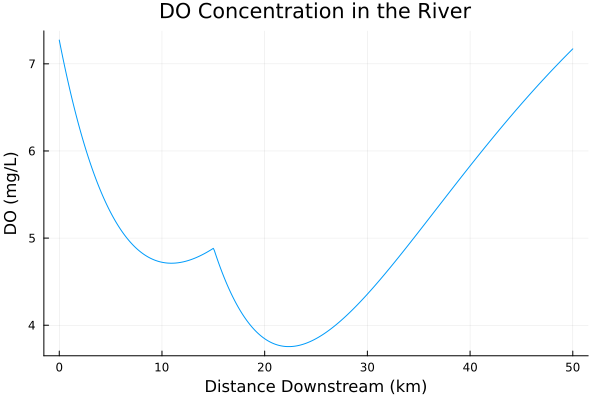

In [85]:
plot(d, C_val, label = false)
xlabel!("Distance Downstream (km)")
ylabel!("DO (mg/L)")
title!("DO Concentration in the River")

After the discharge from waste stream 1, the DO concentration decreases from 7.5 mg/L to a minimum value of around 4.7 mg/L, and then begins to recover. Then at 15 km downstream, discharge from waste stream 2 is added so the DO concentration decreases again and reaches a minimum value of about 3.75 mg/L 22.3 km downstream. As distance increases past 22.3 km, the DO concentration increases and re-establishes back to 7.5 mg/L at 50 km downstream.  

### Problem 3 (3 points)

Under the assumptions of Problem 1, determine the distance from waste
stream 2 it will take for the dissolved oxygen concentration of the
river to recover to 6 mg/L.

In [89]:
d = 15
C = diss_O2(d, 10, 7.5, 50, 45, 35, 35, 0.55, 0.35, 0.25, 6) # DO concentration at 15 km downstream

while C <= 6 # C is calculated at every distance step from 15 km onwards untill we reach the distance at which DO is no longer < 6
    C = diss_O2(d, 10, 7.5, 50, 45, 35, 35, 0.55, 0.35, 0.25, 6)
    d += 0.1 # updating the distance we're checking at 
end
return d 

dist_6 = round(d - 15, digits = 2) # taking the difference to get answer in terms of distance from ws2

26.3

ANSWER: It will take 26.3 km from waste stream 2 for the dissolved oxygen concentration of the river to recover to 6 mg/L.

### Problem 4 (5 points)

What is the minimum level of treatment (% removal of organic waste) for
waste stream 2 that will ensure that the dissolved oxygen concentration
never drops below 4 mg/L, assuming that waste stream 1 remains
untreated?

trt_percent = 12.0
C_min = 4.0


C_min_dist = 21.7


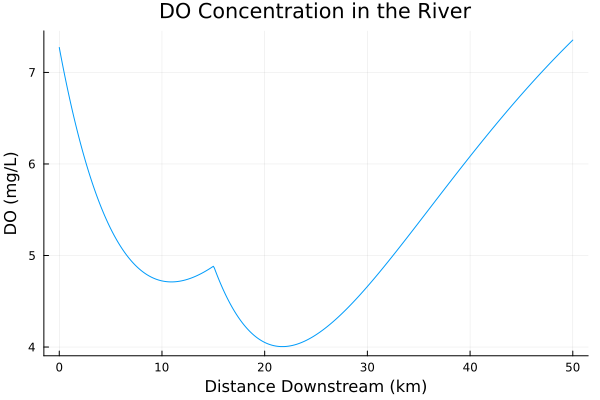

In [103]:
# logic: if we find the trt% at which the minimum DO is now 4 mg/L, 
# then DO at all other distances along the river will be above 4 mg/L 

trt = 0 # initializing
while C_min <= 4 # trt% will iteratively increase until C_min, which is the value obtained in Problem 1 (P1), is >= 4 mg/L
    trt += 0.01
    C_min = diss_O2(C_min_dist, 10, 7.5, 50, 45*(1-trt), 35, 35*(1-trt), 0.55, 0.35, 0.25, 6) # C_min_dist obtained in P1 
end

trt_percent = 100 * round(trt, digits = 2) 
@show trt_percent;

# testing if trt obtained is valid
    d = collect(0:0.1:50)
    C_val_updated = []
    for i = 1:length(d) # generating DO concentration values for d from 0 to 50 km given ws2 gets treated
        C = diss_O2(d[i], 10, 7.5, 50, 45*(1-trt), 35, 35*(1-trt), 0.55, 0.35, 0.25, 6) 
        append!(C_val_updated, C)
    end

    # checking what the new min DO value is 
    min_DO = findmin(C_val_updated)
    C_min = round(min_DO[1]; digits = 2)
    @show C_min
    C_min_dist = d[min_DO[2]];
    @show C_min_dist;

    # new plot given ws2 is treated by the trt% obtained
    plot(d, C_val_updated, label = false)
    xlabel!("Distance Downstream (km)")
    ylabel!("DO (mg/L)")
    title!("DO Concentration in the River")


ANSWER: A minimum level of treatment of about 12% will ensure that the dissolved oxygen concentration never drops below 4 mg/L, assuming that waste stream 1 remains untreated. 

### Problem 5 (5 points)

If both waste streams are treated equally, what is the minimum level of
treatment (% removal of organic waste) for the two sources required to
ensure that the dissolved oxygen concentration never drops below 4 mg/L?

trt_percent = 9.0
C_min = 4.0
C_min_dist = 21.7


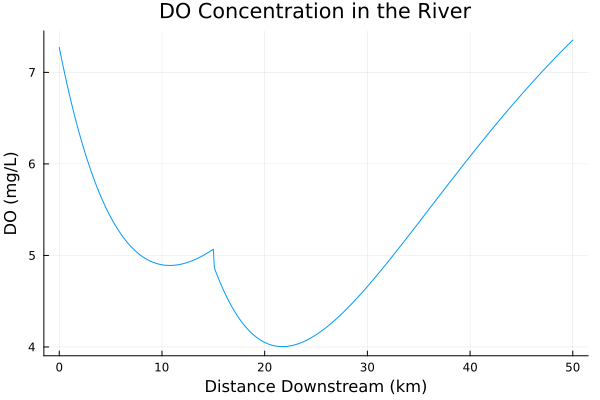

In [108]:
# same logic and execution as P4, but now reduction in CBOD and NBOD is applied to ws1 as well 

trt = 0
while C_min <= 4
    trt += 0.01
    C_min = diss_O2(C_min_dist, 10, 7.5, 50*(1-trt), 45*(1-trt), 35*(1-trt), 35*(1-trt), 0.55, 0.35, 0.25, 6)
end

trt_percent = 100 * round(trt, digits = 2) 
@show trt_percent;

# testing if trt obtained is valid
    d = collect(0:0.1:50)
    C_val_updated = []
    for i = 1:length(d)
        C = diss_O2(d[i], 10, 7.5, 50*(1-trt), 45*(1-trt), 35*(1-trt), 35*(1-trt), 0.55, 0.35, 0.25, 6) 
        append!(C_val_updated, C)
    end

    min_DO = findmin(C_val_updated)
    C_min = round(min_DO[1]; digits = 2)
    @show C_min
    C_min_dist = d[min_DO[2]];
    @show C_min_dist;

    plot(d, C_val_updated, label = false)
    xlabel!("Distance Downstream (km)")
    ylabel!("DO (mg/L)")
    title!("DO Concentration in the River")

ANSWER: The minimum level of treatment for the two sources is about 9% to to ensure that the dissolved oxygen concentration never drops below 4 mg/L. 

### Problem 6 (5 points)

Suppose you are responsible for designing a waste treatment plan for
discharges into the river, with a regulatory mandate to keep the
dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt
to treat waste stream 2 alone or both waste streams equally. What other
information might you need to make a conclusion, if any?

ANSWER: Only treating waste stream 2 will satisfy the regulatory mandate, but waste stream 1 has a larger negative impact on the DO concentration, so the issue of fairness and proportionally assigning responsibility arises. Therefore, factors and information such as cost of compliance, fairness, treatment capacity/available resources will need to be considered to make a decision. 

### Problem 7 (5 points)

Suppose that it is known that the DO concentrations at the river inflow
can vary uniformly between 6 mg/L and 8 mg/L. How often will the
treatment plan identified in Problem 5 (both waste streams treated
equally) fail to comply with the regulatory standard?

In [79]:
Random.seed!(1)

r_Ci_distrib = Uniform(6, 8)
r_Ci = rand(r_Ci_distrib, 100)

d = collect(0:0.1:50)
C_val = []
fail = 0

for i = 1:length(r_Ci)
    for e = 1:length(d)
        C = diss_O2(d[e], 10, r_Ci[i], 50*(1-trt), 45*(1-trt), 35*(1-trt), 35*(1-trt), 0.55, 0.35, 0.25, 6)
        C_val = append!(C_val, C)
    end
    C_min = findmin(C_val)
    if C_min[1] < 4
        fail += 1
    else
        fail += 0
    end
end

@show fail 

fail_freq = fail / length(r_Ci)
@show fail_freq;


fail = 0
fail_freq = 0.0


### Problem 8 (5 points)

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of
5000 L</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

Assume that the treatment plan you identified in Problem 5 is still in
place for the existing discharges. If the third discharge will not be
treated, under the original inflow conditions (7.5 mg/L DO), how far
downstream from the second discharge does this third discharge need to
be placed to keep the river concentration from dropping below 4 mg/L?

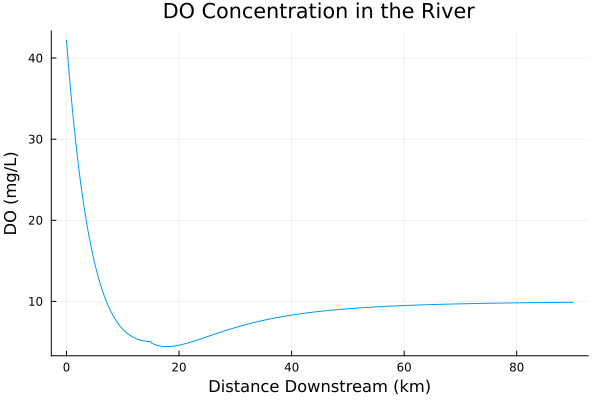

In [76]:
# river, waste stream 1, and waste stream 2 inflows
r_in = 100000
ws1_in = 10000
ws2_in = 15000
ws3_in = 5000
# given DO concentrations
ws1_Ci = 5
ws2_Ci = 5
# given CBOD concentrations
r_Bi = 5
# given NBOD concentrations
r_Ni = 5

function diss_02_ws3(d, Cs, r_Ci, ws3_Ci, ws1_Bi, ws2_Bi, ws3_Bi, ws1_Ni, ws2_Ni, ws3_Ni, ka, kc, kn, U)
    C0 = ((r_Ci * r_in) + (ws1_Ci * ws1_in))/(r_in + ws1_in)
    B0 = ((r_Bi * r_in) + (ws1_Bi * ws1_in))/(r_in + ws1_in)
    N0 = ((r_Ni * r_in) + (ws1_Ni * ws1_in))/(r_in + ws1_in)

    d3 = d - 15

    α1 = exp(-ka * d3 / U) 
    α2 = (kc / (ka - kc)) * (exp(-kc * d3 / U) - α1)
    α3 = (kn / (ka - kn)) * (exp(-kn * d3 / U) - α1)

    Cd_mix = (((diss_O2(d, 10, 7.5, 50*(1-trt), 45*(1-trt), 35*(1-trt), 35*(1-trt), 0.55, 0.35, 0.25, 6)) * (r_in + ws1_in + ws2_in)) + (ws3_Ci * ws3_in))/(r_in + ws1_in + ws2_in + ws3_in)
    Bd_mix = (((B0 * exp(-kc * d / U)) * (r_in + ws1_in + ws2_in)) + (ws3_Bi * ws3_in))/(r_in + ws1_in + ws2_in + ws3_in)
    Nd_mix = (((N0 * exp(-kn * d / U)) * (r_in + ws1_in + ws2_in)) + (ws3_Ni * ws3_in))/(r_in + ws1_in + ws2_in + ws3_in)

    C = (Cs * (1 - α1)) + (Cd_mix * α1) - (Bd_mix * α2) - (Nd_mix * α3)
end

d = collect(0:0.1:15)
C_val_15 = []
for i = 1:length(d)
    C = diss_02_ws3(d[i], 10, 7.5, 4.5, 50*(1-trt), 45*(1-trt), 50, 35*(1-trt), 35*(1-trt), 45, 0.55, 0.35, 0.25, 6)
    append!(C_val_15, C)
end

d = collect(15.01:0.1:90)
C_val_50 = []
for i = 1:length(d)
    C = diss_02_ws3(d[i], 10, 7.5, 4.5, 50*(1-trt), 45*(1-trt), 50, 35*(1-trt), 35*(1-trt), 45, 0.55, 0.35, 0.25, 6)
    append!(C_val_50, C)
end

x = collect(0:0.1:90)
C_val = vcat(C_val_15, C_val_50)

plot(x, C_val, label = false)
xlabel!("Distance Downstream (km)")
ylabel!("DO (mg/L)")
title!("DO Concentration in the River")
 
    

In [59]:
diss_O2(16, 10, 7.5, 50*(1-trt), 45*(1-trt), 35*(1-trt), 35*(1-trt), 0.55, 0.35, 0.25, 6)

4.617659842384872

## References

List any external references consulted, including classmates.

https://www.tutorialspoint.com/julia/julia_arrays.htm

https://www.geeksforgeeks.org/getting-minimum-element-along-with-its-index-in-julia-findmin-method/

Consulted with: Christine Swanson